# Day 14

## Part 1

- Rocks on a reflector!
- `O` rocks can roll
- `#` rocks can't
- Rock load on the north support beams is more or less the moment vs the south side so a rock on the top row produces load len(grid), and -1 for each row back to the bottom.
- Find the total rolling rock load.

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np

from advent_of_code_utils.advent_of_code_utils import (
    ParseConfig, parse_from_file, markdown, create_gif, plot_grid
)

EMPTY = 0
CUBE = 1
ROUND = 2

def tile_parser(tile: str) -> int:
    """converts a tile to an encoded int"""
    match tile:
        case '.':
            return EMPTY
        case '#':
            return CUBE
        case 'O':
            return ROUND
        case _:
            raise ValueError(f'Unknown tile: {tile}')

parser = ParseConfig('\n', ParseConfig('', tile_parser))

grid = parse_from_file('puzzle_input\\day_14.txt', parser)

Text(0.5, 1.0, "Let's rock!")

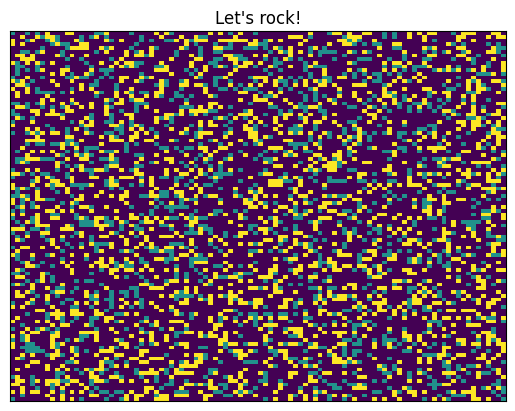

In [2]:
# obligatory plot! - Maybe I should pop this into the utils
fig, ax = plt.subplots()
plot_grid(grid, ax)
ax.set_title('Let\'s rock!')

In [3]:
frames = [grid]

def hashable(grid: list[list[int]]) -> tuple[tuple[int]]:
    """returns a hashable version of the grid"""
    return tuple([tuple(row) for row in grid])

while True:
    previous = frames[-1]
    next_frame = deepcopy(previous)
    for n_row in range(1, len(next_frame)):
        for n_col, value in enumerate(next_frame[n_row]):
            # skip non round tiles
            if value != ROUND:
                continue
            # if the tile above is empty move this round to there and make this
            # tile empty
            if next_frame[n_row - 1][n_col] == EMPTY:
                next_frame[n_row - 1][n_col] = value
                next_frame[n_row][n_col] = EMPTY
    
    # if nothing has changed break out of the loop
    if hashable(next_frame) == hashable(previous):
        break
    # else keep going and append the new frame
    else:
        frames.append(next_frame)   

In [4]:
create_gif(frames, plot_grid, 'day_14', title='Rock and roll-ing')

generating frames:   3%|▎         | 1/36 [00:00<00:04,  8.12it/s]

generating frames: 100%|██████████| 36/36 [00:02<00:00, 13.04it/s]


![Rolling north](day_14.gif)

In [5]:
# nice, now let's solve!
final_frame = frames[-1]

total_north_moment = 0
for n_row, row in enumerate(final_frame):
    for value in row:
        if value == ROUND:
            total_north_moment += len(final_frame) - n_row

markdown(
    '### Solution',
    f'The total load on the north support is: {total_north_moment}'
)

### Solution
The total load on the north support is: 106997

## Part 2
- The spin cycle tips the whole thing `north`, `west`, `south`, `east`
- Doing all 4 is one cycle
- Find the total load on the north support after 1 billion cycles.


Presumably the positions should repeat after a certain point so let's run it for a while and see.

In [6]:
from tqdm import tqdm

In [7]:
n_cycles = 1_000_000_000

In [8]:
cached_frames = [grid]

def tip_north(
    grid: list[list[int]], cache: bool = False, cache_list: list = []
) -> list[list[int]]:
    """returns the grid after it has been tipped north"""
    previous = grid
    while True:
        next_frame = deepcopy(previous)
        for n_row in range(1, len(next_frame)):
            for n_col, value in enumerate(next_frame[n_row]):
                # skip non round tiles
                if value != ROUND:
                    continue
                # if the tile above is empty move this round to there and make this
                # tile empty
                if next_frame[n_row - 1][n_col] == EMPTY:
                    next_frame[n_row - 1][n_col] = value
                    next_frame[n_row][n_col] = EMPTY
        
        # if nothing has changed break out of the loop
        if hashable(next_frame) == hashable(previous):
            return previous
        # else keep going and append the new frame if caching enabled
        elif cache:
            temp = deepcopy(next_frame)
            for func in cache_list:
                temp = func(temp)
            cached_frames.append(temp)
        previous = next_frame


def tip_south(
    grid: list[list[int]], cache: bool = False, cache_list: list = [np.flipud]
) -> list[list[int]]:
    """returns the grid after it has been tipped south"""
    return np.flipud(tip_north(np.flipud(grid), cache, cache_list))

def tip_west(
    grid: list[list[int]], cache: bool = False,
    cache_list: list = [np.transpose]
) -> list[list[int]]:
    """returns the grid after it has been tipped west"""
    return np.transpose(tip_north(np.transpose(grid), cache, cache_list))

def tip_east(
    grid: list[list[int]], cache: bool = False,
    cache_list: list = [np.transpose, np.fliplr]
) -> list[list[int]]:
    """returns the grid after it has been tipped east"""
    return np.fliplr(tip_west(np.fliplr(grid), cache, cache_list))


Let's just run it for 10 cycles because caching all these frames isn't going to be very easy once it runs for too long

In [9]:
previous_full_cycle = grid
cached_frames = [grid]
cache = True

for iteration in tqdm(range(n_cycles), total=n_cycles):
    next_cycle = deepcopy(previous_full_cycle)
    next_cycle = tip_north(next_cycle, cache)
    next_cycle = tip_west(next_cycle, cache)
    next_cycle = tip_south(next_cycle, cache)
    next_cycle = tip_east(next_cycle, cache)
    
    if hashable(next_cycle) == hashable(previous_full_cycle):
        break
    else:
        previous_full_cycle = next_cycle
    
    if iteration >= 10:
        break

  0%|          | 10/1000000000 [00:06<187145:30:33,  1.48it/s]


In [10]:
create_gif(
    cached_frames, plot_grid, 'day_14_part_2', append_iteration=True,
    title='First 10 cycles'
)

generating frames: 100%|██████████| 1478/1478 [01:33<00:00, 15.87it/s]


![10 Cycles](day_14_part_2.gif)

Ok now for real

In [56]:
previous_full_cycle = grid
cache = False

for iteration in tqdm(range(n_cycles), total=n_cycles):
    next_cycle = deepcopy(previous_full_cycle)
    next_cycle = tip_north(next_cycle, cache)
    next_cycle = tip_west(next_cycle, cache)
    next_cycle = tip_south(next_cycle, cache)
    next_cycle = tip_east(next_cycle, cache)
    
    if hashable(next_cycle) == hashable(previous_full_cycle):
        break
    else:
        previous_full_cycle = next_cycle
    

  0%|          | 558/1000000000 [05:49<174073:10:29,  1.60it/s]


KeyboardInterrupt: 

Hmm, this doesn't seem to be stabilising. At least, not at just over 1 iteration per second, that is.

This will need optimisation to solve. Potentially we could build a map of where a `ROUND` rock at some location ends up once it stabilises and streamline the iterations to only have to simulate the ones that are still filtering out.